<a href="https://colab.research.google.com/github/cruzdany/KERAS-NLP/blob/main/NLP_Assignment05_Maga%C3%B1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import re
from numpy import *  
import matplotlib.pyplot as plt
import numpy as np
import operator
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
df = pd.read_csv('train.csv',encoding='utf-8',error_bad_lines=False, engine="python")

In [3]:
"""import nltk
nltk.download('stopwords')"""

"import nltk\nnltk.download('stopwords')"

In [4]:
"""from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
import re

def scrub_words(text):
    # remove html markup
    text=re.sub("(<.*?>)","",text)
    
    #remove non-ascii and digits
    text=re.sub("(\\W|\\d)"," ",text)
  
    #remove whitespace
    text=text.strip()
    return text
  
#Noise removal, stop word removal, normalizing?
def cleanString(s, special_chars = "\":,.@|ðÿœžðÿâœœïÿœžÿºÿÿœžÿ=_"):
    for char in special_chars:
        s = s.replace(char, "")
    s = s.replace("\n", "")
    s = scrub_words(s)
    tokenizer = TweetTokenizer()
    stop_words = set(stopwords.words('english'))
    cleaned_words = [w for w in tokenizer.tokenize(s) if w not in stop_words]
    return " ".join(cleaned_words), tokenizer

def stemWords(sentence):
    stemmer, tokenizer = PorterStemmer(), TweetTokenizer()
    stemmed_words = [stemmer.stem(w) for w in tokenizer.tokenize(sentence)]
    return " ".join(stemmed_words)
    
def cleanFrame(frame):
    frame['clean_tweet'] = frame.comment_text.apply(cleanString)


cleanFrame(df)
df.head()"""

'from nltk.corpus import stopwords\nfrom nltk.tokenize import TweetTokenizer\nfrom nltk.stem import PorterStemmer\nimport re\n\ndef scrub_words(text):\n    # remove html markup\n    text=re.sub("(<.*?>)","",text)\n    \n    #remove non-ascii and digits\n    text=re.sub("(\\W|\\d)"," ",text)\n  \n    #remove whitespace\n    text=text.strip()\n    return text\n  \n#Noise removal, stop word removal, normalizing?\ndef cleanString(s, special_chars = "":,.@|ðÿœžðÿâœœïÿœžÿºÿÿœžÿ=_"):\n    for char in special_chars:\n        s = s.replace(char, "")\n    s = s.replace("\n", "")\n    s = scrub_words(s)\n    tokenizer = TweetTokenizer()\n    stop_words = set(stopwords.words(\'english\'))\n    cleaned_words = [w for w in tokenizer.tokenize(s) if w not in stop_words]\n    return " ".join(cleaned_words), tokenizer\n\ndef stemWords(sentence):\n    stemmer, tokenizer = PorterStemmer(), TweetTokenizer()\n    stemmed_words = [stemmer.stem(w) for w in tokenizer.tokenize(sentence)]\n    return " ".join(st

Import Pickle

In [5]:
import re
special_chars = r"[^0-9!@#\$%\^\&\*_\-']"
def Cleaning(tweet,special_chars):
    tweet = re.sub("\d+", "", tweet)
    tweet=re.sub("h[\S]+//[\S]+", "", tweet)
    tweet=re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet)
    tweet=tweet.lower()
    for char in special_chars:
        tweet = tweet.replace(char, "")    
    tweet=tweet.split(" ")
    return ' '.join(tweet)
Cleaned=[]
for t in df["comment_text"]:
    Cleaned.append(Cleaning(t,special_chars))
df['text_generation'] = Cleaned
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_generation
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanationwhy the edits made under my usernam...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww he matches this background colour im seem...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man im really not trying to edit war its j...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,morei cant make any real suggestions on improv...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...


In [6]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'text_generation'],
      dtype='object')

In [7]:
y = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.text_generation, y, test_size=0.2,
                                                    random_state=np.random)
print(X_train.shape, X_test.shape, len(y_train), len(y_test))

(127656,) (31915,) 127656 31915


In [9]:
from keras.preprocessing.text import Tokenizer
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
maxlen=400
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
V_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
V_test = pad_sequences(list_tokenized_test, maxlen=maxlen)
print(V_train.shape,V_test.shape)

(127656, 400) (31915, 400)


In [10]:
"""def getModel():
    inp = Input(shape=(maxlen, ))
    embed_size = 128
    x = Embedding(max_features, embed_size)(inp)
    x = LSTM(30, return_sequences=True,name='lstm_layer')(x)
    #x = GlobalMaxPool1D()(x)
    #x = Dropout(0.5)(x)
    x = Dense(20, activation="relu")(x)
    #x = Dropout(0.5)(x)
    x = Dense(6, activation="sigmoid")(x)
    x = 
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model"""

'def getModel():\n    inp = Input(shape=(maxlen, ))\n    embed_size = 128\n    x = Embedding(max_features, embed_size)(inp)\n    x = LSTM(30, return_sequences=True,name=\'lstm_layer\')(x)\n    #x = GlobalMaxPool1D()(x)\n    #x = Dropout(0.5)(x)\n    x = Dense(20, activation="relu")(x)\n    #x = Dropout(0.5)(x)\n    x = Dense(6, activation="sigmoid")(x)\n    x = \n    model = Model(inputs=inp, outputs=x)\n    model.compile(loss=\'binary_crossentropy\',\n                      optimizer=\'adam\',\n                      metrics=[\'accuracy\'])\n    return model'

In [11]:
def getModel():
    inp = Input(shape=(maxlen, ))
    embed_size = 128
    x = Embedding(max_features, embed_size)(inp)
    x = LSTM(30, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [12]:
"""def getModel():
    inp = Input(shape=(maxlen, ))
    embed_size = 128
    x = Embedding(max_features, embed_size)(inp)
    x = LSTM(30, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model"""

'def getModel():\n    inp = Input(shape=(maxlen, ))\n    embed_size = 128\n    x = Embedding(max_features, embed_size)(inp)\n    x = LSTM(30, return_sequences=True,name=\'lstm_layer\')(x)\n    x = GlobalMaxPool1D()(x)\n    x = Dropout(0.5)(x)\n    x = Dense(20, activation="relu")(x)\n    x = Dropout(0.5)(x)\n    x = Dense(6, activation="sigmoid")(x)\n    model = Model(inputs=inp, outputs=x)\n    model.compile(loss=\'binary_crossentropy\',\n                      optimizer=\'adam\',\n                      metrics=[\'accuracy\'])\n    return model'

In [13]:
"""def getModel():
    inp = Input(shape=(maxlen, ))
    embed_size = 128
    x = Embedding(max_features, embed_size)(inp)
    x = LSTM(30, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(6, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model"""

'def getModel():\n    inp = Input(shape=(maxlen, ))\n    embed_size = 128\n    x = Embedding(max_features, embed_size)(inp)\n    x = LSTM(30, return_sequences=True,name=\'lstm_layer\')(x)\n    x = GlobalMaxPool1D()(x)\n    x = Dropout(0.5)(x)\n    x = Dense(20, activation="relu")(x)\n    x = Dropout(0.5)(x)\n    x = Dense(6, activation="softmax")(x)\n    model = Model(inputs=inp, outputs=x)\n    model.compile(loss=\'binary_crossentropy\',\n                      optimizer=\'adam\',\n                      metrics=[\'accuracy\'])\n    return model'

In [14]:
model = getModel()
batch_size = 32
epochs = 3
file_path="../weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)


callbacks_list = [checkpoint, early] #early
model.fit(V_train,y_train,  batch_size=batch_size, epochs=epochs, 
          validation_split=0.1, callbacks=callbacks_list)

model.load_weights(file_path)

Epoch 1/3
3591/3591 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.8948
Epoch 00001: val_loss improved from inf to 0.05058, saving model to ../weights_base.best.hdf5
3591/3591 [==============================] - 737s 205ms/step - loss: 0.0803 - accuracy: 0.8948 - val_loss: 0.0506 - val_accuracy: 0.9941
Epoch 2/3
3591/3591 [==============================] - ETA: 0s - loss: 0.0498 - accuracy: 0.9886
Epoch 00002: val_loss did not improve from 0.05058
3591/3591 [==============================] - 744s 207ms/step - loss: 0.0498 - accuracy: 0.9886 - val_loss: 0.0506 - val_accuracy: 0.9941
Epoch 3/3
3591/3591 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9858
Epoch 00003: val_loss improved from 0.05058 to 0.04939, saving model to ../weights_base.best.hdf5
3591/3591 [==============================] - 739s 206ms/step - loss: 0.0450 - accuracy: 0.9858 - val_loss: 0.0494 - val_accuracy: 0.9941


In [15]:
from sklearn.pipeline import Pipeline

y_pred = model.predict(V_test)
print(classification_report(y_test,y_pred.round(),digits=6))

              precision    recall  f1-score   support

           0   0.812227  0.767132  0.789036      3152
           1   0.857143  0.017804  0.034884       337
           2   0.831938  0.780584  0.805443      1782
           3   0.000000  0.000000  0.000000        95
           4   0.721178  0.697999  0.709399      1649
           5   0.000000  0.000000  0.000000       311

   micro avg   0.794306  0.677860  0.731477      7326
   macro avg   0.537081  0.377253  0.389794      7326
weighted avg   0.753581  0.677860  0.696682      7326
 samples avg   0.069346  0.065508  0.064548      7326



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
y_pred = model.predict(V_test)
print(classification_report(y_test,y_pred.round(),digits=6))

              precision    recall  f1-score   support

           0   0.812227  0.767132  0.789036      3152
           1   0.857143  0.017804  0.034884       337
           2   0.831938  0.780584  0.805443      1782
           3   0.000000  0.000000  0.000000        95
           4   0.721178  0.697999  0.709399      1649
           5   0.000000  0.000000  0.000000       311

   micro avg   0.794306  0.677860  0.731477      7326
   macro avg   0.537081  0.377253  0.389794      7326
weighted avg   0.753581  0.677860  0.696682      7326
 samples avg   0.069346  0.065508  0.064548      7326



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
#y_pred = (y_pred > 0.5) 

In [18]:
confusion_matrix(y_test, y_pred)

ValueError: ignored

In [20]:
y_pred

array([[2.99614668e-03, 2.39340068e-07, 2.22027302e-04, 3.43457191e-06,
        1.49637461e-04, 2.87444309e-05],
       [2.43712664e-02, 5.91088292e-06, 2.23308802e-03, 6.82577011e-05,
        2.29689479e-03, 3.68684530e-04],
       [6.84529543e-03, 2.07970828e-07, 7.76141882e-04, 2.61999844e-06,
        3.97890806e-04, 2.86688173e-05],
       ...,
       [1.01902485e-02, 3.26631744e-06, 1.11916661e-03, 2.52368609e-05,
        8.32468271e-04, 1.57624483e-04],
       [1.50877535e-02, 1.63330128e-06, 9.92596149e-04, 1.89494549e-05,
        1.05017424e-03, 1.34855509e-04],
       [3.21583748e-02, 3.45748958e-05, 3.89593840e-03, 2.12460756e-04,
        3.88252735e-03, 9.03904438e-04]], dtype=float32)

In [21]:
y_test

,toxic,severe_toxic,obscene,threat,insult,identity_hate
147194,0,0,0,0,0,0
128427,0,0,0,0,0,0
10932,0,0,0,0,0,0
108365,0,0,0,0,0,0
96767,0,0,0,0,0,0
...,...,...,...,...,...,...
14462,0,0,0,0,0,0
133114,0,0,0,0,0,0
105795,0,0,0,0,0,0
15846,0,0,0,0,0,0


In [ ]:
confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

In [ ]:
df.shape

In [22]:
history = model.fit(V_train,y_train,  batch_size=batch_size, epochs=epochs, 
                    validation_split=0.1, callbacks=callbacks_list)

Epoch 1/3
3591/3591 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9788
Epoch 00001: val_loss did not improve from 0.04939
3591/3591 [==============================] - 745s 207ms/step - loss: 0.0409 - accuracy: 0.9788 - val_loss: 0.0522 - val_accuracy: 0.9941
Epoch 2/3
3591/3591 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9451
Epoch 00002: val_loss did not improve from 0.04939
3591/3591 [==============================] - 741s 206ms/step - loss: 0.0376 - accuracy: 0.9451 - val_loss: 0.0527 - val_accuracy: 0.9940
Epoch 3/3
3591/3591 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9260
Epoch 00003: val_loss did not improve from 0.04939
3591/3591 [==============================] - 744s 207ms/step - loss: 0.0346 - accuracy: 0.9260 - val_loss: 0.0538 - val_accuracy: 0.9941
Epoch 00003: early stopping


In [23]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [27]:
y_pred = model.predict(V_test)
print(classification_report(y_test,y_pred.round(),digits=6))

              precision    recall  f1-score   support

           0   0.772140  0.777284  0.774704      3152
           1   0.497992  0.367953  0.423208       337
           2   0.831224  0.773850  0.801511      1782
           3   0.000000  0.000000  0.000000        95
           4   0.731148  0.676167  0.702583      1649
           5   0.000000  0.000000  0.000000       311

   micro avg   0.767181  0.691783  0.727534      7326
   macro avg   0.472084  0.432542  0.450334      7326
weighted avg   0.721882  0.691783  0.705889      7326
 samples avg   0.069654  0.066868  0.065395      7326



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
import matplotlib.pyplot as plt

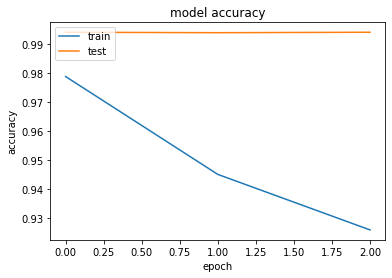

In [25]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

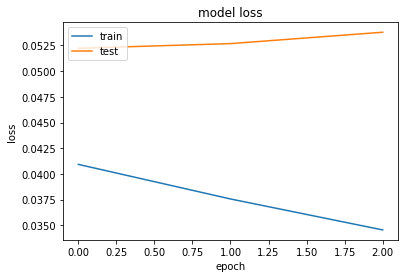

In [26]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()